# <팀 커널 브리핑>

#### (1) What are lung opacities

####  - https://www.kaggle.com/zahaviguy/what-are-lung-opacities

####  - 멤버 : Hyun soo

#### (2) Lung opacitiy overview

#### - https://www.kaggle.com/kmader/lung-opacity-overview

#### - 멤버 : Heewon, Hyuna
 
#### 　
 
#### (3) Exploratory Data Analysis (*here)

####  - https://www.kaggle.com/peterchang77/exploratory-data-analysis

####  - 멤버 : JiHye, Kiwon

####  - 내용 :

#### 1. 프로젝트 설명

####  - 이 프로젝트는 흉부 방사선 사진(2D 회색조 의료 사진)에서 폐렴 진단에 필요한 경계 부근(네모 박스)를 발결하는 것이 목표이다.

####   폐렴은 흉부 엑스레이 사진에서 발생할 수 있는 여러 질병 중 하나이고, 

####   이미지 결과 값에 폐렴 위치에 해당하는 곳에 0개, 1개 혹은 많은 박스가 나타나게 되면서 확인할 수 잇다.

In [75]:
#import libs...
import glob, pylab, pandas as pd
import pydicom, numpy as np

#### 2. 데이터

#### (1) 데이터 로드

####  - 데이터는 여러 파일과 폴더로 구성되는데, 캐글 커널에서 이용하는 경우 "~~~" 디렉토리에 사전 로드 되어 있다.

In [55]:
#show file list
!ls ./all

stage_1_detailed_class_info.csv  stage_1_test_images   stage_1_train_labels.csv
stage_1_sample_submission.csv	 stage_1_train_images


 #### (2) 이 데이터 폴더의 주요 항목

####   1) stage_1_train_labels.csv : 바운딩 상자를 포함하는 교육용 트레이닝 세트

####   2) stage_1_detail_class_info.csv : 자세한 라벨이 포함된 CSV 파일 (PID, CLASS)

####   3) stage_1_train_images : 트레이닝 세트의 로우 이미지가 들어 있는 파일

####   - CSV 파일의 각 행에는 환자아이디(고유한 값), 폐렴여부(1 or 0), 비정상적인 경계상자의 좌표(x,y)와 폭 높이가 있다. 

#### 폐렴이 없으면 NaN으로 표시된다. 또한, 폐렴환자는 여러 바운딩 박스를 가질 수 있다.

####   - 환자의 ID에서 폐렴이 두 개 이상 감지될 경우 여러 개의 상자가 나타날 수 있다.

In [76]:
#read data filie
df = pd.read_csv('./all/stage_1_train_labels.csv')
print(df.iloc[0]) #print information of first row in df(dataframe)

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [36]:
print(df.iloc[4]) #print information of fifth row in df(dataframe)

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


#### 3. DICOM 파일 및 의료 이미지

####  (1) DICOM 파일 및 의료 이미지

####   - 의료 영상은 DICOM 파일(*.dcm) 이라고 하는 특수 형식으로 저장된다.

####   - 여기에는 헤더 메타데이터와 픽셀 데이터의 로우 이미지가 함께 들어 있다.

 
####  (2) DICOM 파일 및 의료 이미지 이용

####   - Python에서는, DICOM 파일에 접근하고 조작하는데 pydicom 라이브러리를 이용한다.

####   - pydicom 라이브러리를 사용하려면 먼저 stage_1_train_images/folder에서 원하는 파일을 찾고,

####     pydicom.read_file()을 사용하여 데이터를 로드하면 된다.

####   - 픽셀 배열은 Numpy 배열로 저장된다. Numpy 배열은 행렬 데이터를 처리하고 조작하기 위한 강력한 숫자 파이썬 라이브러리이다. 

In [7]:
patientId = df['patientId'][0]
dcm_file = './all/stage_1_train_images/%s.dcm' % patientId # 환자아이디와 일치하는 파일 찾기
dcm_data = pydicom.read_file(dcm_file) # load data using pydicom.read_file() method

print(dcm_data) #로드한 데이터 출력

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

#### 환자 식별 정보가 포함 된 표준 헤더의 대부분은 익명 처리 (삭제)되어 있으므로 상대적으로 희소 한 메타 데이터 집합이 남아있다. 액세스 할 기본 필드는 다음과 같은 기본 픽셀 데이터입니다.

In [9]:
im = dcm_data.pixel_array #위에서 저장한 환자 의료 데이터 파일
print(type(im))  
print(im.dtype)
print(im.shape)

<type 'numpy.ndarray'>
uint8
(1024, 1024)


 #### (3) 원본 방사선 사진 사전 처리 작업

####   1) The relatively high dynamic range 높은 비트-depth 원본이미지는 8비트 인코딩으로 재조정되었다. 

#### 특정 질병을 강조하기 위해 방사선 의사가 수동으로 조정한다. 

####   2) 상대적으로 큰 원본 이미지는 1024*1024 사이즈로 조정되었다. 

#### 이 과제의 목절을 위해, 대부분의 폐렴 진단은 이 해상도로 수행할 수 있다. 

#### 폐렴 검출을 위한 최적의 해상도(더 낮은 해상도로도 검출 가능)를 결정하고 시각적으로 평가하기 위해서는 전문가와 상의해야 한다.


####  (4) DICOM 시각화

####  - DICOM 이미지를 보려면 pylab.imshow()를 이용하면 된다.

(-0.5, 1023.5, 1023.5, -0.5)

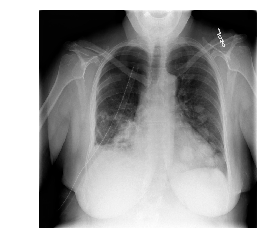

In [39]:
pylab.imshow(im, cmap=pylab.cm.gist_gray) #회색조로 출력
pylab.axis('off') #좌표

#### 4. 데이터 및 라벨의 탐색

####  (1) 데이터 및 라벨의 탐색

####   - 앞에서 살펴 봤듯이, 폐렴이 의심스러운 영역이 있을 경우, 결과 값에는 많은 박스가 포함 된다.

####  (2) 방법

####   *현재 CSV 파일 데이터 프레임을 고유한 항목이 있는 사전으로 축소하려면 다음 방법을 고려하면 된다.

In [44]:
def parse_data(df): #데이터 파싱
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """ 
    # --- Define lambda to extract coords in list [y, x, height, width], 이미지맵 좌표
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']] #lambda는 한줄로 함수 만드는 것이다. 

    parsed = {} #초기화
    for n, row in df.iterrows():  #순환반복, n is not used
        # --- Initialize patient entry into parsed 
        pid = row['patientId'] 
        
        #parsed 안에 pid가 없다면,아래와 같은 형태로 파싱 및 저장
        if pid not in parsed:
            parsed[pid] = {
                'dicom': './all/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}  #처음에는 boxes 비고.
            
        # 폐렴이면 boxes에 데이터 추가
        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

#### - 또한 이 방법을 이용하면 된다.

In [69]:
parsed = parse_data(df)

#### (3) 실습 1

####  - 앞에서 본 바와 같이, 00436515-870c-4b36-a041-d91049b9ab4는 pnuemonia를 가지고 있으므로, 바운딩 박스를 가진 환자인지 확인하도록 하겠다.

In [70]:
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': './all/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]], 'label': 1}


####   - 원본 회색 음영 DICOM 파일에 색상 상자를 오버레이하려면 다음 방법을 사용하면 된다.

####   (아래의 main 메소드 draw ()는 overlay_box () 메소드가 필요하다.)

In [74]:
def draw(data):

    """
    Method to draw single patient with bounding box(es) if present 
    바운딩 박스 그리기
    """

    # DICOM 이미지 파일을 연다.
    d = pydicom.read_file(data['dicom']) #위에서 파싱한 데이터 중 dicom 라벨, 의료 사진 가져오기
    im = d.pixel_array #이미지 회색조로

    # Single Channel인 그레이 에서 3 Channel인 RGB로 변환
    im = np.stack([im] * 3, axis=2)

    # 랜덤의 색이 있는 박스를 추가
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int') #랜덤 색
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6) #박스

    pylab.imshow(im, cmap=pylab.cm.gist_gray) #화면에 표시
    pylab.axis('off')


def overlay_box(im, box, rgb, stroke=1):
    """
    단일 상자를 이미지에 추가하기
    """

    # 좌표 값을 정수로 변환
    box = [int(b) for b in box]
    
    # --- 좌표값 추출
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width
 
    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

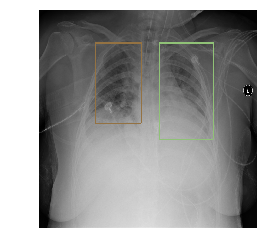

In [73]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

#### (4) Detail한 라벨 탐색

####  - 이 대회에서 주요 포인트는 폐렴의 유무와 같은 이진 binary classification의 탐지이다.

#### 단, binary classification의 분류 외에도 폐렴에 박스가 뜨지 않는 것들은 정상 혹은 무폐로 분류가 된다.

#### 또한, 폐렴이 존재하지 않는 것으로 판명된 것 중에 '이미지 자체에 문제가 있는 경우'도 있다.

#### 이런 경우에는 종종 폐렴과 혼돈될 수 있다.

#### 따라서 이러한 것들을 위해, 알고리즘의 정확성을 향상시키기 위해 보충 정보가 제공 된다.

#### (하지만 이 클래스가 이 챌린지에서 평가를 위해 사용되는 공식 매트릭스는 아니다.)

In [51]:
df_detailed = pd.read_csv('./all/stage_1_detailed_class_info.csv')
print(df_detailed.iloc[0]) #첫행에 있는 환자 정보 출력

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


####  (5) 실습 2

####  - 위와 같이, 우리는 CSV 파일의 첫 번째 환자가 폐렴을 가지지 않았다는 것을 알았다.

#### 이 환자에 대한 자세한 라벨 정보를 살펴보도록 하겠다.

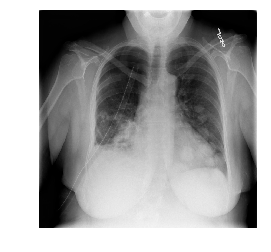

In [66]:
#폐렴은 가지고 있지 않지만 다른 이상을 가진 환자 그리기
patientId = df_detailed['patientId'][0]
draw(parsed[patientId])

#### 표시된 이미지는 아주 작지만, 방사선 전문의로서 보면 환자는 왼쪽 폐에 결절 밀도를 가지고 있다. 
#### 또한 오른쪽 폐에 체액 축적(흉곽 유출)을 배수하기 위해 큰 흉곽 튜브를 가지고 있으며, 이는 패치 집적도를 나타낼 수 있다. 
#### 살펴본 바와 같이, 이미지에는 여러 이상이 있었다. 하지만 이러한 이상이 '폐렴과 관련 없다'는 것은 의사들 사이에서도 주관적인 의견이므로, 확언할 수 없다. 
#### 따라서 제공된 데이터 세트로는 100%의 알고리즘을 만들 수 없다. 방사선 전문의와 상의하여 최적의 전략을 만드는 것이 좋다.

#### (6) 마지막으로
####  - 데이터 세트의 라벨 분포를 자세히 살펴보자. 먼저 디테일한 라벨 정보를 분석해야 한다.

In [77]:
summary = {} #초기화
for n, row in df_detailed.iterrows(): #순환반복
    if row['class'] not in summary: 
        summary[row['class']] = 0 #처음 등장하는 class가 있다면 추가하고 0으로 초기화
    summary[row['class']] += 1 #기존에 있는 class이면 ++만 하기
    
print(summary) 

{'Lung Opacity': 8964, 'No Lung Opacity / Not Normal': 11500, 'Normal': 8525}


####    보다 시피, 세 가지 클래스 사이에는 상대적으로 균일한 분할이 있으며, 데이터의 거의 2/3가 폐렴 없이 구성되어 있다.

####    질병의 확산률이 매우 낮은 대부분의 의료 영상 데이터 세트와 비교하여 this dataset has been significantly enriched with pathology.(의료기술이 발전했다.??)

####    데이터 구조, 이미징 파일 형식 및 라벨 유형을 이해했으니 이제 알고리즘을 만들 때이다! 기본적으로 목표는 바운딩 박스 탐지이므로 object localization algorithms을 고려할 수 있다.

####    **An alternative strategy is to consider the related family of segmentation algorithms with the acknowledgement that bounding boxes will only be a coarse approximation to true pixel-by-pixel image segmentation masks.**

In [79]:
type(summary) #summary data type is dict

dict